# 导入相关的包

In [1]:
import torch
import torch.nn as nn
from torch import optim
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, precision_recall_curve

# 重要参数设置

In [14]:
NUM_SEQUENCES = 1000 # 患者数量 # batch_size
TIME_STEPS = 24*6 # 时间步 # sequence_length
NUM_FEATURES = 6 # HR RR SpO2 Temp SBP DBP # input_size
NUM_CLASSES = 1  # 假设有两个类别
beta = 1

DEVICE = 'mps'

BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

# LSTM
HiDDEN_SIZE = 256
NUM_LAYERS =2
DROPOUT_RATE = 0.2
BIDIRECTIONAL = True

# Linear_1
OUTPUT_SIZE_li_1 = 128

# Linear_2
OUTPUT_SIZE_li_2 = 10

# 模拟数据生成模块

In [3]:
def synthetic_data(X, Y, num_sequences,time_steps, num_features):
    """0为正弦，1为直线"""
    generate_type = 0   
    for i in tqdm(range(num_sequences//2), desc="Generating sine sequences"):  # 添加进度条
        Y[i] = generate_type
        for k in range(num_features):
            for j in range(time_steps):
                X[i,j,k] = np.sin(j) - np.random.random() * beta
    generate_type = 1 
    for i in tqdm(range(num_sequences//2, num_sequences), desc="Generating linear sequences"):  # 添加进度条
        Y[i] = generate_type
        for k in range(num_features):
            for j in range(time_steps):
                X[i,j,k] = -1 + np.random.random() * beta  
    return X, Y

In [4]:
data_tensor = torch.zeros(NUM_SEQUENCES, TIME_STEPS, NUM_FEATURES)
label_tensor = torch.zeros(NUM_SEQUENCES)
data_tensor.to(DEVICE)
label_tensor.to(DEVICE)
print(DEVICE)

mps


In [5]:
features , labels = synthetic_data(data_tensor, label_tensor, NUM_SEQUENCES, TIME_STEPS, NUM_FEATURES)

Generating linear sequences: 100%|██████████| 500/500 [00:01<00:00, 403.11it/s]


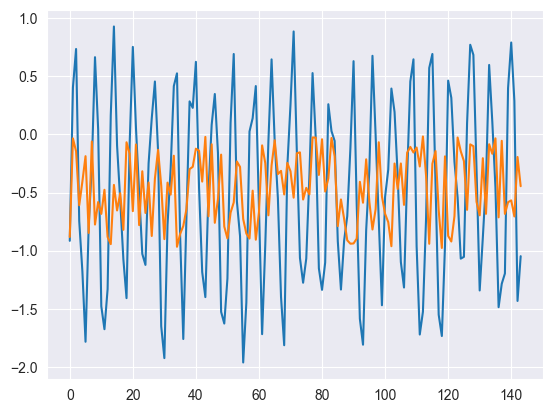

In [6]:
y_1_values = features[0,:,0].tolist()
y_2_values = features[-1,:,0].tolist()
x_values = torch.arange(TIME_STEPS).tolist()
plt.plot(x_values, y_1_values, y_2_values)

# 训练准备工作

# 分化训练集和测试集

In [7]:
test_features = torch.cat((features[:NUM_SEQUENCES//10],
                           features[-NUM_SEQUENCES//10:]), dim=0)
test_labels = torch.cat((labels[:NUM_SEQUENCES//10], 
                         labels[-NUM_SEQUENCES//10:]), dim=0)

train_features = torch.cat((features[NUM_SEQUENCES//10:-NUM_SEQUENCES//10],
                            features[-NUM_SEQUENCES//10:]), dim=0)
train_labels = torch.cat((labels[NUM_SEQUENCES//10:-NUM_SEQUENCES//10],
                          labels[-NUM_SEQUENCES//10:]), dim=0)

In [8]:
from torch.utils.data import DataLoader, TensorDataset

# 将生成器转换为数据集
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 定义LSTM模型

In [9]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=BIDIRECTIONAL)
        self.fc1 = nn.Linear(hidden_size * 2 if BIDIRECTIONAL else hidden_size
                             , OUTPUT_SIZE_li_1) 
        self.fc2 = nn.Linear(OUTPUT_SIZE_li_1, OUTPUT_SIZE_li_2) 
        self.fc3 = nn.Linear(OUTPUT_SIZE_li_2, NUM_CLASSES)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * (2 if BIDIRECTIONAL else 1),
                         x.size(0), 
                         self.hidden_size).to(DEVICE) 
        c0 = torch.zeros(self.num_layers * (2 if BIDIRECTIONAL else 1),
                         x.size(0), 
                         self.hidden_size).to(DEVICE)
        
        # LSTM层
        out, _ = self.lstm(x, (h0, c0))
        
        # 取最后一个时间步的输出
        out = out[:, -1, :]
        
        # 两个线性层
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))
        return out.squeeze(1).to(DEVICE)


## 创建模型实例

In [10]:
model = LSTMClassifier(
    NUM_FEATURES, 
    hidden_size=HiDDEN_SIZE, 
    num_layers=NUM_LAYERS, 
    num_classes=NUM_CLASSES)
model.to(DEVICE)

LSTMClassifier(
  (lstm): LSTM(6, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [11]:
for X,y in train_loader:
    X, y = X.to(DEVICE), y.to(DEVICE)
    input_data = X
    print("Input shape:", input_data.shape)
    
    # 模型预测
    output = model(input_data)
    print("Output shape:", output.shape)  
    
    label = y
    print("label shape:", label.shape)  

    break

Input shape: torch.Size([64, 144, 6])
Output shape: torch.Size([64])
label shape: torch.Size([64])


# 创建损失函数和更新函数

In [12]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 开始训练

In [15]:
for epoch in range(NUM_EPOCHS):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    
    for X, y in tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}'):
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()  # 梯度清零
        
        # 正向传播
        outputs = model(X)
        loss = criterion(outputs, y.float())
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X.size(0)
    
    # 计算平均损失
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}')

Epoch 1/10: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s]


Epoch [1/10], Loss: 0.3935


Epoch 2/10: 100%|██████████| 15/15 [00:01<00:00,  9.07it/s]


Epoch [2/10], Loss: 0.0141


Epoch 3/10: 100%|██████████| 15/15 [00:01<00:00,  9.15it/s]


Epoch [3/10], Loss: 0.0004


Epoch 4/10: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


Epoch [4/10], Loss: 0.0001


Epoch 5/10: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


Epoch [5/10], Loss: 0.0001


Epoch 6/10: 100%|██████████| 15/15 [00:01<00:00,  8.57it/s]


Epoch [6/10], Loss: 0.0000


Epoch 7/10: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


Epoch [7/10], Loss: 0.0000


Epoch 8/10: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Epoch [8/10], Loss: 0.0000


Epoch 9/10: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Epoch [9/10], Loss: 0.0000


Epoch 10/10: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]

Epoch [10/10], Loss: 0.0000


# 评估模型

In [70]:
model.eval()  # 设置模型为评估模式
y_predict = torch.empty(0, dtype=torch.float32, device=DEVICE)
y_true = torch.empty(0, dtype=torch.float32, device=DEVICE)
for X, y in test_loader:
    X, y = X.to(DEVICE), y.to(DEVICE)
    new_data = X  # 准备待预测的数据
    prediction = model(new_data)
    prediction_class = (prediction >= 0.5).float()  
    y_predict = torch.cat([y_predict, prediction_class.unsqueeze(1)], dim=0)
    y_true = torch.cat([y_true, y.unsqueeze(1)], dim=0)

# 二分类问题绘制混淆矩阵

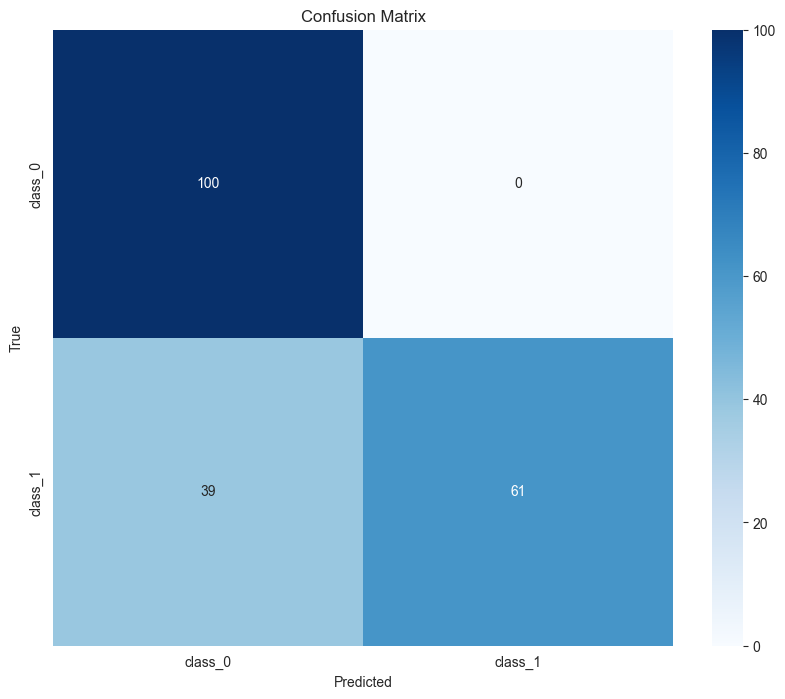

In [71]:
# 计算混淆矩阵
cm = confusion_matrix(y_true.cpu().numpy().flatten(), y_predict.cpu().numpy().flatten())

# 绘制混淆矩阵图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['class_0', 'class_1'], yticklabels=['class_0', 'class_1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


模型的准确率Accuracy：0.805

模型的精确率precision：1.0

模型的召回率Recall：0.61

模型的F1-Score：0.7577639751552795

模型的均方误差：0.19499999284744263


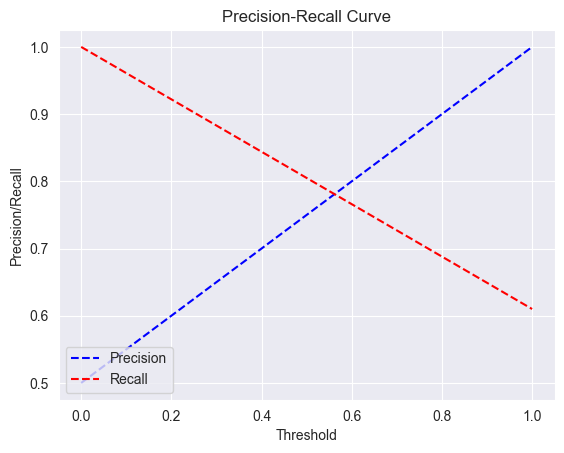

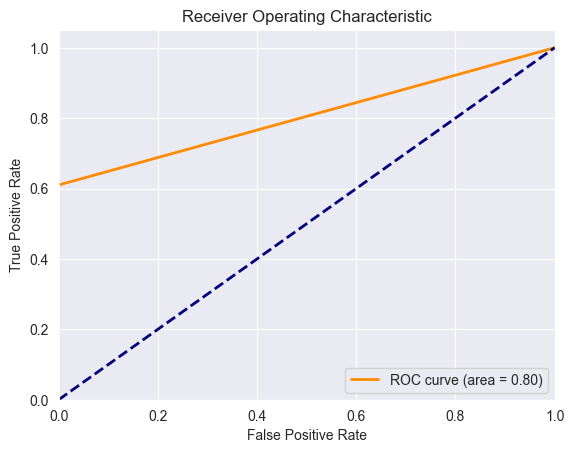

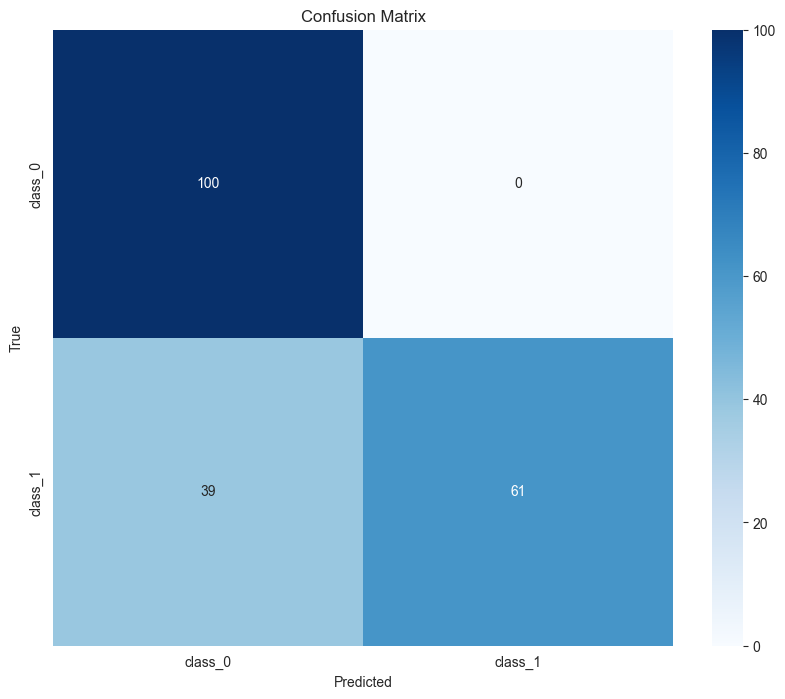

In [76]:
# 设置模型为评估模式
model.eval()  

# 初始化变量
y_predict = torch.empty(0, dtype=torch.float32, device=DEVICE)
y_true = torch.empty(0, dtype=torch.float32, device=DEVICE)

# 预测每个样本的标签
for X, y in test_loader:
    X, y = X.to(DEVICE), y.to(DEVICE)  # 将数据移动到指定设备上
    new_data = X  # 准备待预测的数据
    prediction = model(new_data)
    prediction_class = (prediction >= 0.5).float()  
    y_predict = torch.cat([y_predict, prediction_class.unsqueeze(1)], dim=0)
    y_true = torch.cat([y_true, y.unsqueeze(1)], dim=0)

# 计算准确率
accuracy = accuracy_score(y_true.cpu(), y_predict.cpu())
print(f"模型的准确率Accuracy：{accuracy}\n")

# 计算精确率
precision = precision_score(y_true.cpu(), y_predict.cpu())
print(f"模型的精确率precision：{precision}\n")

# 计算召回率
recall = recall_score(y_true.cpu(), y_predict.cpu())
print(f"模型的召回率Recall：{recall}\n")

# 计算F1指数
f1 = f1_score(y_true.cpu(), y_predict.cpu())
print(f"模型的F1-Score：{f1}\n")

# 计算均方误差
mse = ((y_true.cpu() - y_predict.cpu()) ** 2).mean()
print(f"模型的均方误差：{mse}\n")


# 计算召回率-阈值曲线
precision, recall, thresholds = precision_recall_curve(y_true.cpu(), y_predict.cpu())

# 绘制召回率-阈值曲线
plt.figure()
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'r--', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# 计算ROC曲线和AUC
fpr, tpr, thresholds = roc_curve(y_true.cpu(), y_predict.cpu())
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 计算混淆矩阵
cm = confusion_matrix(y_true.cpu().numpy().flatten(), y_predict.cpu().numpy().flatten())

# 绘制混淆矩阵图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['class_0', 'class_1'], yticklabels=['class_0', 'class_1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

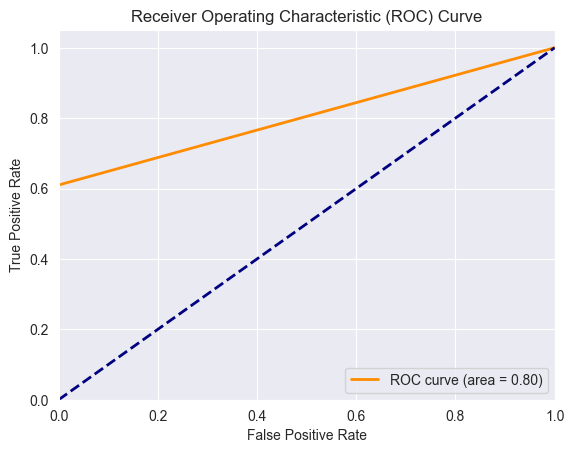

In [77]:
# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_true.cpu(), y_predict.cpu())

# 计算AUC
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()